In [10]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir ./dataset
!unzip /content/drive/MyDrive/FaceAge.zip -d ./dataset

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./dataset/train/49_38550.jpg  
  inflating: ./dataset/train/49_38551.jpg  
  inflating: ./dataset/train/49_38552.jpg  
  inflating: ./dataset/train/49_38553.jpg  
  inflating: ./dataset/train/49_38554.jpg  
  inflating: ./dataset/train/49_38555.jpg  
  inflating: ./dataset/train/49_38556.jpg  
  inflating: ./dataset/train/49_38557.jpg  
  inflating: ./dataset/train/49_38558.jpg  
  inflating: ./dataset/train/49_38559.jpg  
  inflating: ./dataset/train/49_38560.jpg  
  inflating: ./dataset/train/49_38561.jpg  
  inflating: ./dataset/train/49_38562.jpg  
  inflating: ./dataset/train/49_38563.jpg  
  inflating: ./dataset/train/49_38564.jpg  
  inflating: ./dataset/train/49_38565.jpg  
  inflating: ./dataset/train/49_38566.jpg  
  inflating: ./dataset/train/49_38567.jpg  
  inflating: ./dataset/train/49_38568.jpg  
  inflating: ./dataset/train/49_38569.jpg  
  inflating: ./dataset/train/49_38570.jpg  
  inflating: ./dataset/train/49_38571.jp

In [2]:
import os
import sys
import time
import torch
import numpy as np
from glob import glob
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.notebook import tqdm as tqdm


In [3]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)
        
        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        #plt.imshow(np.transpose(img, (1, 2, 0)))
        #plt.show()
        return img

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2

class canny(object):
    def __call__(self, img):
      h = img.size(1)
      w = img.size(2)
      mask = np.zeros((h, w), np.float32)

      img = np.transpose(img, (1, 2, 0))
      img = img.numpy()*255
      img = img.astype(np.uint8)
      #canny1 = cv2.Canny(img, threshold1=50, threshold2=200)
      #anny2 = cv2.Canny(img, threshold1=100, threshold2=200)
      canny3 = cv2.Canny(img, threshold1=170, threshold2=200)
      img = np.array((canny3, canny3, canny3))
      img = torch.from_numpy(img)/255
      return img

In [5]:
'''ResNet18/34/50/101/152 in Pytorch.'''

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.linear = nn.Linear(512,num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes)

# test_resnet()

In [6]:
class AverageMeter(object):
    r"""Computes and stores the average and current value
    """
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, *meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def print(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def accuracy(output, target, topk=(1,)):
    r"""Computes the accuracy over the $k$ top predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # _, pred = output.topk(maxk, 1, True, True)
        # pred = pred.t()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))

        # faster topk (ref: https://github.com/pytorch/pytorch/issues/22812)
        _, idx = output.sort(descending=True)
        pred = idx[:,:maxk]
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [7]:
model = 'resnet18' # resnet18, resnet50, resnet101
batch_size = 128  # Input batch size for training (default: 128)
epochs = 1000 # Number of epochs to train (default: 100)
learning_rate = 1e-4 # Learning rate
data_augmentation = True # Traditional data augmentation such as augmantation by flipping and cropping?
cutout = True # Apply Cutout?
n_holes = 1 # Number of holes to cut out from image
length = 16 # Length of the holes
seed = 0 # Random seed (default: 0)
num_classes = 1 ##regression
print_freq = 30
num_workers = 1
cuda = torch.cuda.is_available()
cudnn.benchmark = True  # Should make training should go faster for large models
train_val_ratio = 0.9

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [11]:
import matplotlib.pyplot as plt
class FacialDataset(Dataset):
    def __init__(self, data_path):
        if not os.path.exists(data_path):
            raise Exception(f"[!] {self.data_path} not existed")
        self.imgs = []
        self.labels = []
        self.transform1 = transforms.Compose([
            transforms.ToTensor(),                                 
            transforms.Resize((64,64))
        ])
        self.transform2 = transforms.Compose([
            transforms.ToTensor(),                                 
            transforms.Resize((64,64)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30)
        ])
        
        self.age_path = sorted(glob(os.path.join(data_path, "*.*")))
        for pth in self.age_path:
          img = Image.open(pth)
          label = int(pth.split('_')[0].split('/')[-1])
          self.labels.append(label)
          #self.labels.append(label)
          #self.imgs.append(self.transform1(img))
          self.imgs.append(self.transform1(img))

    def __getitem__(self, idx):
        image = self.imgs[idx]
        label = self.labels[idx]
        return image , label

    def __len__(self):
        return len(self.age_path)

def get_data_loader(data_path, batch_size, num_workers,train_val_ratio):
    full_dataset = FacialDataset(data_path)
    train_size = int(train_val_ratio * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
   
    torch.manual_seed(3334)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers, pin_memory=False)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=False,num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader

train_loader, val_loader = get_data_loader('/content/dataset/train',batch_size,num_workers,train_val_ratio)

In [12]:
import copy

def train(train_loader, epoch, model, optimizer):
    batch_time = AverageMeter('Time', ':6.3f')
    l2 = AverageMeter('L2 Loss', ':.4e')
    l1 = AverageMeter('L1 Loss', ':.4e')
    progress = ProgressMeter(len(train_loader), batch_time, l2,l1, prefix="Epoch: [{}]".format(epoch))
    # switch to train mode
    model.train()
    l1_criterion = nn.L1Loss().cuda()
    l2_criterion = nn.MSELoss().cuda()
    end = time.time()
    for i, (input, label) in enumerate(train_loader):
        input_copy1 = copy.deepcopy(input)
        #input_copy2 = copy.deepcopy(input)
        input_copy3 = copy.deepcopy(input)
        # measure data loading time
        trans1 = transforms.Compose([ 
            Cutout(n_holes=1, length=16),
        ])
        #trans2 = transforms.Compose([ 
            #canny(),
        #])
        trans3 = transforms.Compose([ 
            transforms.RandomRotation((-45, 45)),
        ])
        input_1 = []
        #input_2 = []
        input_3 = []
        for a in input_copy1:
          input_1.append(trans1(a).numpy())
        #for b in input_copy2:
          #input_2.append(trans2(b).numpy())
        for c in input_copy3:
          input_3.append(trans3(c).numpy())
        input_1 = torch.FloatTensor(input_1)
        #input_2 = torch.FloatTensor(input_2)
        input_3 = torch.FloatTensor(input_3)
        input_1 = input_1.cuda()
        #input_2 = input_2.cuda()
        input_3 = input_3.cuda()
        input = input.cuda()
        label = label.float().flatten().cuda()
        # compute output
        output = model(input).flatten()
        output_1 = model(input_1).flatten()
        #output_2 = model(input_2).flatten()
        output_3 = model(input_3).flatten()
        #output = F.relu(output)
        l2_ = l2_criterion(output, label)
        l1_ = l1_criterion(output,label)
        l2.update(l2_.item(), input.size(0))
        l1.update(l1_.item(), input.size(0))

        # argumentation
        l2_ = l2_criterion(output_1, label)
        l1_ = l1_criterion(output_1,label)
        l2.update(l2_.item(), input.size(0))
        l1.update(l1_.item(), input.size(0))

        #l2_ = l2_criterion(output_2, label)
        #l1_ = l1_criterion(output_2,label)
        #l2.update(l2_.item(), input.size(0))
        #l1.update(l1_.item(), input.size(0))

        l2_ = l2_criterion(output_3, label)
        l1_ = l1_criterion(output_3,label)
        l2.update(l2_.item(), input.size(0))
        l1.update(l1_.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        l2_.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            progress.print(i)
        #print('==> Train Accuracy: Loss {losses:.3f} || scores {r2_score:.4e}'.format(losses=losses, r2_score=r2))

def validation(val_loader,epoch, model):
    model.eval()
    l2 = torch.nn.MSELoss().cuda()
    for i,(input,label) in enumerate(val_loader):
        input = input.cuda()
        label = label.float().flatten().cuda()
        output = model(input).flatten()
        l2_ = l2(label,output)
        RMSE = torch.sqrt(l2_)
    print('==> Validate Accuracy:  L2 distance {:.3f} || RMSE {:.3f}'.format(l2_,RMSE))
    return RMSE


###########################################################
model = ResNet18(num_classes=num_classes).cuda()

# Check number of parameters your model
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {pytorch_total_params}")
if int(pytorch_total_params) > 2000000:
    print('Your model has the number of parameters more than 2 millions..')
    sys.exit()

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True, weight_decay=5e-4)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.95, eps=1e-08, weight_decay=5e-4, momentum=0.9)

scheduler = MultiStepLR(optimizer, milestones=[60, 90, 120], gamma=0.2)

best_acc = 1e5
for epoch in range(epochs):
    print("\n----- epoch: {}, lr: {} -----".format(
        epoch, optimizer.param_groups[0]["lr"]))

    # train for one epoch
    start_time = time.time()
    train(train_loader, epoch, model, optimizer)
    val_acc = validation(val_loader,epoch,model)

    elapsed_time = time.time() - start_time
    print('==> {:.2f} seconds to train this epoch\n'.format(elapsed_time))
    # learning rate scheduling
    scheduler.step()
    
    # Save model for best accuracy
    if best_acc > val_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'model_best.pt')

    torch.save(model.state_dict(),'model_latest.pt')
print(f"Best RMSE Accuracy: {best_acc}")

Number of parameters: 1287617

----- epoch: 0, lr: 0.0001 -----
Epoch: [0][  0/307]	Time  1.015 ( 1.015)	L2 Loss 1.2566e+03 (1.2558e+03)	L1 Loss 3.1938e+01 (3.1932e+01)
Epoch: [0][ 30/307]	Time  0.443 ( 0.461)	L2 Loss 1.8884e+02 (3.7431e+02)	L1 Loss 9.6985e+00 (1.4109e+01)
Epoch: [0][ 60/307]	Time  0.432 ( 0.448)	L2 Loss 1.3431e+02 (2.7892e+02)	L1 Loss 8.5918e+00 (1.1784e+01)
Epoch: [0][ 90/307]	Time  0.438 ( 0.446)	L2 Loss 1.3847e+02 (2.3809e+02)	L1 Loss 8.2246e+00 (1.0836e+01)
Epoch: [0][120/307]	Time  0.446 ( 0.443)	L2 Loss 1.7557e+02 (2.1346e+02)	L1 Loss 9.1158e+00 (1.0247e+01)
Epoch: [0][150/307]	Time  0.452 ( 0.443)	L2 Loss 1.3006e+02 (2.0018e+02)	L1 Loss 8.4898e+00 (9.9363e+00)
Epoch: [0][180/307]	Time  0.435 ( 0.442)	L2 Loss 1.3108e+02 (1.8858e+02)	L1 Loss 8.2757e+00 (9.6342e+00)
Epoch: [0][210/307]	Time  0.434 ( 0.442)	L2 Loss 1.2054e+02 (1.8007e+02)	L1 Loss 7.8346e+00 (9.4079e+00)
Epoch: [0][240/307]	Time  0.436 ( 0.441)	L2 Loss 9.8836e+01 (1.7175e+02)	L1 Loss 7.0931e+00 (9.1

KeyboardInterrupt: ignored

In [14]:
'''ResNet18/34/50/101/152 in Pytorch.'''

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=2)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.linear = nn.Linear(512,num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.relu(out)


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes)

def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3,4,6,3], num_classes)

def ResNet50(num_classes=10):
    return ResNet(Bottleneck, [3,4,6,3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(Bottleneck, [3,4,23,3], num_classes)

def ResNet152(num_classes=10):
    return ResNet(Bottleneck, [3,8,36,3], num_classes)

# test_resnet()

In [15]:
class FacialDataset_test(Dataset):
    def __init__(self, data_path):
        if not os.path.exists(data_path):
            raise Exception(f"[!] {self.data_path} not existed")
        self.imgs = []
        self.transform = transforms.Compose([
            transforms.ToTensor(),                                 
            transforms.Resize((64,64)),
            #transforms.Normalize([0.5748, 0.4525, 0.3981], [0.2284, 0.2018, 0.1866])
        ])
        self.age_path = sorted(glob(os.path.join(data_path, "*.*")))
        for pth in self.age_path:
          img = Image.open(pth)
          self.imgs.append(self.transform(img))
    def __getitem__(self, idx):
        image = self.imgs[idx]
        return image

    def __len__(self):
        return len(self.age_path)

import torch
import pandas as pd
import argparse
import time
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

def eval():
    test_dataset = FacialDataset_test("/content/dataset/test")
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)

    model = ResNet18(num_classes=num_classes).cuda()
    model.load_state_dict(torch.load('/content/model_best.pt'))
    model.eval()
    
    print('Make an evaluation csv file for submission...')
    Category = []
    for input in test_loader:
        input = input.cuda()
        output = [model(input).item()]
        #input = input.cpu()
        #npimg = np.array(input)
        #plt.title(output)
        #plt.imshow(npimg[0][0])
        #plt.show()
        # output = torch.argmax(output, dim=1)
        Category = Category + output

    Id = list(range(0, len(test_loader)))
    samples = {
       'Id': Id,
       'Category': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Category'])

    df.to_csv('/content/submission_best.csv', index=False)
    print('Done!!')

    del model
    model = ResNet18(num_classes=num_classes).cuda()
    model.load_state_dict(torch.load('/content/model_latest.pt'))
    model.eval()
    
    print('Make an evaluation csv file for submission...')
    Category = []
    for input in test_loader:
        input = input.cuda()
        output = [model(input).item()]
        #input = input.cpu()
        #npimg = np.array(input)
        #plt.title(output)
        #plt.imshow(np.transpose(npimg[0], (1, 2, 0)))
        #plt.show()
        # output = torch.argmax(output, dim=1)
        Category = Category + output

    Id = list(range(0, len(test_loader)))
    samples = {
       'Id': Id,
       'Category': Category 
    }
    df = pd.DataFrame(samples, columns=['Id', 'Category'])

    df.to_csv('/content/submission_latest.csv', index=False)
    print('Done!!')

if __name__ == "__main__":
    eval()

Make an evaluation csv file for submission...
Done!!
Make an evaluation csv file for submission...
Done!!


<class 'numpy.ndarray'>
(200, 200, 3)
(200, 200)


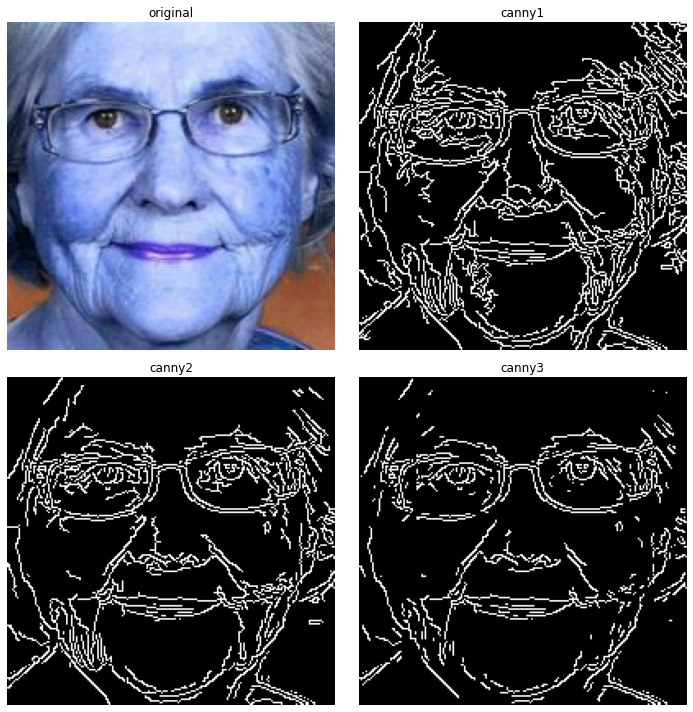

(200, 200, 3)
(200, 200)


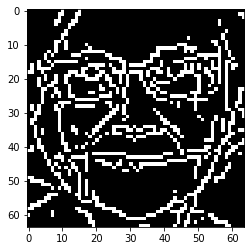

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np

#img3 = cv2.imread("dataset/train/93_43383.jpg", cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread("dataset/train/93_43383.jpg")
print(type(img3))
print(img3.shape)
canny1 = cv2.Canny(img3, 50, 200)
canny2 = cv2.Canny(img3, 100, 200)
canny3 = cv2.Canny(img3, 170, 200)
print(canny1.shape)
titles = ['original', 'canny1', 'canny2', 'canny3']
images = [img3, canny1, canny2, canny3]

plt.figure(figsize=(10,10))
for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.title(titles[i])
  plt.imshow(images[i], cmap='gray')
  plt.axis('off')

plt.tight_layout()
plt.show()
print(img3.shape)
print(canny1.shape)

a = transforms.Compose([ 
            #transforms.Normalize([0.5748, 0.4525, 0.3981], [0.2284, 0.2018, 0.1866]),
            transforms.ToTensor(),
            #Cutout(n_holes=1, length=16),
            transforms.Resize((64,64)),
            canny(),
            #transforms.RandomRotation((-45, 45)),
        ])
img3 = a(img3)
plt.imshow(np.transpose(img3, (1, 2, 0)))
plt.show()

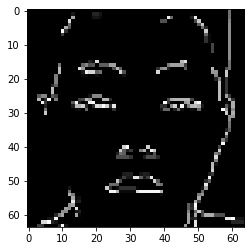

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# 이미지를 보여주기 위한 함수

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()


# 이미지 보여주기
imshow(torchvision.utils.make_grid(images[0]))

In [ ]:
import cv2
import matplotlib.pyplot as plt

input = cv2.imread('hong1.PNG')
t=transforms.Compose([
            transforms.ToTensor(),                                 
            transforms.Resize((64,64)),
        ])
input = t(input)
input = torch.unsqueeze(input, 0)
input = input.cuda()
output = [model(input).item()]
plt.title('Age: {}'.format(output[0]))
o=plt.imread('hong1.PNG')
plt.imshow(o)
plt.show()

TypeError: ignored